In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv('/kaggle/input/movielens-20m-dataset/rating.csv')
df

,userId,movieId,rating,timestamp
0,1,2,3.5,2005-04-02 23:53:47
1,1,29,3.5,2005-04-02 23:31:16
2,1,32,3.5,2005-04-02 23:33:39
3,1,47,3.5,2005-04-02 23:32:07
4,1,50,3.5,2005-04-02 23:29:40
...,...,...,...,...
20000258,138493,68954,4.5,2009-11-13 15:42:00
20000259,138493,69526,4.5,2009-12-03 18:31:48
20000260,138493,69644,3.0,2009-12-07 18:10:57
20000261,138493,70286,5.0,2009-11-13 15:42:24


In [2]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values('timestamp')

In [3]:
df = df.rename(columns={"userId": "userId:token", "movieId": "movieId:token", "timestamp_int": "timestamp:float"})


In [4]:
test_part = 0.2
train_len = int(df.shape[0] * (1 - test_part))
test_len = df.shape[0] - train_len 
df_train, df_test = df.drop(['timestamp'], axis=1).head(train_len), df.drop(['timestamp'], axis=1).tail(test_len)

In [5]:
N_USERS = df['userId:token'].max() + 1
N_ITEMS = df['movieId:token'].max() + 1

In [6]:
import torch

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

In [7]:
from math import log2

def apk(pred, target, k):
    if len(pred) >= k:
        pred = pred[:k]

    ans, cnt = 0, 0
    tot = len(pred) 
    s = set()
    for i in range(len(pred)):
        if pred[i] in target and pred[i] not in s:
            cnt += 1
            ans += cnt / (i + 1)
            s.add(pred[i])
    return ans / tot


def mapk(pred, target, k):
    assert len(pred) == len(target)
    sum_metric = 0
    for cur_pred, cur_target in zip(pred, target):
        sum_metric += apk(cur_pred, cur_target, k)
    return sum_metric / len(pred) 


def mr(pred, target):
    ans, cnt = 0, 0
    tot = len(pred)
    s = set()
    for i in range(len(pred)):
        if pred[i] in target and pred[i] not in s:
            ans += 1 / (i + 1)
            s.add(pred[i])
            break
    return ans

def mrr(pred, target):
    assert len(pred) == len(target)
    sum_metric = 0
    for cur_pred, cur_target in zip(pred, target):
        sum_metric += mr(cur_pred, cur_target)
    return sum_metric / len(pred) 


def ndcgunique(pred, target):
    ans, cnt = 0, 0
    tot = len(pred)
    s = set()
    for i in range(len(pred)):
        if pred[i] in target and pred[i] not in s:
            ans += 1 / (log2(i + 2))
            s.add(pred[i])
    return ans / tot

def ndcg(pred, target):
    assert len(pred) == len(target)
    sum_metric = 0
    for cur_pred, cur_target in zip(pred, target):
        sum_metric += ndcgunique(cur_pred, cur_target)
    return sum_metric / len(pred) 


def precisionunique(pred, target, k):
    if len(pred) >= k:
        pred = pred[:k]

    ans, cnt = 0, 0
    tot = len(pred)
    s = set()
    for i in range(len(pred)):
        if pred[i] in target and pred[i] not in s:
            ans += 1
            s.add(pred[i])
    return ans / tot


def precision(pred, target, k):
    assert len(pred) == len(target)
    sum_metric = 0
    for cur_pred, cur_target in zip(pred, target):
        sum_metric += precisionunique(cur_pred, cur_target, k)
    return sum_metric / len(pred) 

In [8]:
import queue
from tqdm.auto import trange


class GraphDataset(object):
    def __init__(self, df, max_len):
        self.max_len = max_len
        self.df = df
        self.graph = [[] for _ in range(N_USERS)]
        for i in trange(self.df.shape[0]):
            usr, item = self.df['userId:token'].iloc[i], self.df['movieId:token'].iloc[i]
            self.graph[usr].append(item)

    def __getitem__(self, index):
        return self.graph[index][-self.max_len:]

    def __len__(self):
        return len(self.graph)


In [9]:
dataset = GraphDataset(df_train, 128)

  0%|          | 0/16000210 [00:00<?, ?it/s]

In [10]:
import torch

!pip install torch-scatter -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-geometric


Looking in links: https://data.pyg.org/whl/torch-1.11.0.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 535.6 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Created wheel for torch-scatter: filename=torch_scatter-2.1.0-cp37-cp37m-linux_x86_64.whl size=4187463 sha256=48fb489dda28383739a418a55d6637ef0f46b3e60022964c73c875662854555b
  Stored in directory: /root/.cache/pip/wheels/2d/d1/15/8a2f0086896d156654a843fff4bdbeaf621cdd10310a0daad2
Successfully built torch-scatter
Looking in links: https://data.pyg.org/whl/torch-1.11.0.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 208.2/208.2 kB 910.7 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Created wheel for torch-sparse: filename=torch_sparse-0.6.16-cp37-cp37m-linux_x86_64.whl size=1743100 sha256=eddcb87c34040b096a73c98f2c8603095338841a459a4c23bd50f7e39c90181e
  Stored in directory: /root/.cache/pip/wheels/92/8d/17/1517bf0318b8343b665b7aadf906dff4bc8967d82cacc17992
Successfully built torch-s

In [11]:
import torch.nn as nn
import torch_geometric as tg


class SHAN(nn.Module):
    def __init__(self, n_users, n_items, hidden_dim):
        super().__init__()
        self.embedding_items = nn.Embedding(n_items, hidden_dim)
        self.embedding_users = nn.Embedding(n_users, hidden_dim)
        self.additional_info_encoding = nn.Linear(2, hidden_dim)

        self.attention_1 = nn.Linear(2 * hidden_dim, 1)
        self.attention_2 = nn.Linear(2 * hidden_dim, 1)
        self.last_layer = nn.Linear(hidden_dim, n_items)
        self.hidden_dim = hidden_dim

    def forward(self, history_input, metadata, user_id):
        len_long_history = int(history_input.shape[1] * (2/3))
        
        long_history, short_history = history_input[:, :len_long_history], history_input[:, len_long_history:]
        encoded_metadata = self.additional_info_encoding(metadata)
        encoded_long_history = self.embedding_items(long_history) + encoded_metadata[:, :len_long_history, :]
        encoded_short_history = self.embedding_items(short_history) + encoded_metadata[:, len_long_history:, :]
        encoded_user = self.embedding_users(user_id)

        encoded_long_user = torch.cat([encoded_user.unsqueeze(1)] * len_long_history, 1)
        weights_long = self.attention_1(torch.cat([encoded_long_history, encoded_long_user], 2)).softmax(1)
        weights_long = torch.cat([weights_long] * self.hidden_dim, 2)
        output_long = torch.sum(weights_long * encoded_long_history, 1).unsqueeze(1)

        encoded_short_history = torch.cat([encoded_short_history, output_long], 1)
        encoded_short_user = torch.cat([encoded_user.unsqueeze(1)] * encoded_short_history.shape[1], 1)
        #print(encoded_short_history.shape, encoded_short_user.shape)
        weights_short = self.attention_2(torch.cat([encoded_short_history, encoded_short_user], 2)).softmax(1)
        weights_short = torch.cat([weights_short] * self.hidden_dim, 2)
        output_short = torch.sum(weights_short * encoded_short_history, 1)
    
        return self.last_layer(output_short)


In [12]:
model_pizdim_embedding = torch.load('/kaggle/input/shan-model/model.pt').to(device)

In [13]:
import torch.nn as nn
import torch_geometric as tg

class SRGNN(nn.Module):
    def __init__(self, n_items, hidden_dim):
        super().__init__()

        self.embedding = model_pizdim_embedding.embedding_items
        for param in self.embedding.parameters():
            param.requires_grad=False
        self.gnn = tg.nn.GCNConv(hidden_dim, hidden_dim)
        self.attn_layer = nn.Linear(2 * hidden_dim, 1)
        self.lin_layer = nn.Linear(2 * hidden_dim, hidden_dim)

    @staticmethod
    def reorder_tensor(inp_tensor):
        d = {inp_tensor[i].item():i for i in range(inp_tensor.shape[0])}
        return torch.tensor([d[v.item()] for v in inp_tensor]).to(device)

    def forward(self, elem_sequence):
        embeddings = self.embedding(elem_sequence.unsqueeze(0))
        reordered_sequence = self.reorder_tensor(elem_sequence)
        edges = torch.cat([reordered_sequence[:-1].unsqueeze(0), reordered_sequence[1:].unsqueeze(0)], 0)
        hidden = self.gnn(embeddings, edges) # 1, L, H
        sl = hidden[:, -1, :].unsqueeze(0) # 1, 1, H
        pre_attention = torch.cat([sl] * hidden.shape[1], 1)
        attention_output = self.attn_layer(torch.cat([pre_attention, hidden], 2)).squeeze(2) # 1, L
        attention_output = attention_output.softmax(-1).unsqueeze(2) # 1, L, 1
        attention_output = torch.cat([attention_output] * hidden.shape[2], 2)
        sh = torch.sum(attention_output * hidden, 1) # 1, H
        sg = self.lin_layer(torch.cat([sh, sl.squeeze(0)], 1)).T # H, 1
        return (self.embedding.weight @ sg).squeeze(1) # N

In [14]:
model = SRGNN(N_ITEMS, 64).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)
criterion = nn.CrossEntropyLoss()

In [15]:
from tqdm.auto import trange, tqdm
import random

epochs = 4
history = []

for _ in trange(epochs):
    for i in trange(len(dataset)):
        optimizer.zero_grad()
        if len(dataset[i]) < 4:
            continue
        history_len = random.randint(max(len(dataset[i]) // 2, 1), len(dataset[i]) - 1)
        history, target = dataset[i][:history_len], dataset[i][history_len]

        batch = torch.tensor(history).to(device)
        output = model(batch).unsqueeze(0)
        loss = criterion(output, torch.tensor([target]).to(device))
        history.append(loss.item())
        loss.backward()
        optimizer.step()

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/138494 [00:00<?, ?it/s]

  0%|          | 0/138494 [00:00<?, ?it/s]

  0%|          | 0/138494 [00:00<?, ?it/s]

  0%|          | 0/138494 [00:00<?, ?it/s]

In [16]:
torch.save(model, 'model.pt')


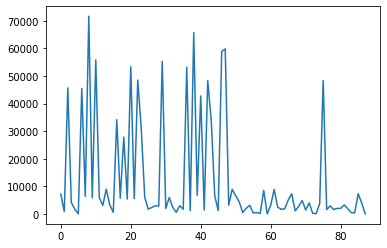

In [17]:
import pickle
with open("metrics.txt", 'wb') as f:
    pickle.dump(history, f)
import matplotlib.pyplot as plt
import numpy as np

plt.plot(np.arange(len(history)), history)


In [18]:
@torch.no_grad()
def reccomend_for_user(user_id, k):
    history = dataset[user_id]
    answer = []

    for i in range(k):
        batch = torch.tensor(history).to(device)
        output = model(batch).argmax(-1).item()
        history.append(output)
        answer.append(output)
    return answer


In [19]:
from math import log2

def apk(pred, target, k):
    if len(pred) >= k:
        pred = pred[:k]

    ans, cnt = 0, 0
    tot = len(pred) 
    s = set()
    for i in range(len(pred)):
        if pred[i] in target and pred[i] not in s:
            cnt += 1
            ans += cnt / (i + 1)
            s.add(pred[i])
    return ans / tot


def mapk(pred, target, k):
    assert len(pred) == len(target)
    sum_metric = 0
    for cur_pred, cur_target in zip(pred, target):
        sum_metric += apk(cur_pred, cur_target, k)
    return sum_metric / len(pred) 

def mr(pred, target):
    ans, cnt = 0, 0
    tot = len(pred)
    s = set()
    for i in range(len(pred)):
        if pred[i] in target and pred[i] not in s:
            ans += 1 / (i + 1)
            s.add(pred[i])
            break
    return ans

def mrr(pred, target):
    assert len(pred) == len(target)
    sum_metric = 0
    for cur_pred, cur_target in zip(pred, target):
        sum_metric += mr(cur_pred, cur_target)
    return sum_metric / len(pred) 


def ndcgunique(pred, target):
    ans, cnt = 0, 0
    tot = len(pred)
    s = set()
    for i in range(len(pred)):
        if pred[i] in target and pred[i] not in s:
            ans += 1 / (log2(i + 2))
            s.add(pred[i])
    return ans / tot

def ndcg(pred, target):
    assert len(pred) == len(target)
    sum_metric = 0
    for cur_pred, cur_target in zip(pred, target):
        sum_metric += ndcgunique(cur_pred, cur_target)
    return sum_metric / len(pred) 


def precisionunique(pred, target, k):
    if len(pred) >= k:
        pred = pred[:k]

    ans, cnt = 0, 0
    tot = len(pred)
    s = set()
    for i in range(len(pred)):
        if pred[i] in target and pred[i] not in s:
            ans += 1
            s.add(pred[i])
    return ans / tot


def precision(pred, target, k):
    assert len(pred) == len(target)
    sum_metric = 0
    for cur_pred, cur_target in zip(pred, target):
        sum_metric += precisionunique(cur_pred, cur_target, k)
    return sum_metric / len(pred) 


In [20]:
test_dataset = GraphDataset(df_test, int(1e9))

  0%|          | 0/4000053 [00:00<?, ?it/s]

In [21]:
test_dataset[0]

[]

In [22]:
predictions = []
target = []
k = 20
for i in trange(len(test_dataset)):
    if len(test_dataset[i]) == 0 or len(dataset[i]) == 0:
        continue
    out = reccomend_for_user(i, k)
    predictions.append(out)
    target.append(test_dataset[i])


  0%|          | 0/138494 [00:00<?, ?it/s]

In [23]:
for i in range(1, 20):
    print(f"precision@{i} : {precision(predictions, target, i)}")
print(f"ndcg: {ndcg(predictions, target)}")
print(f"mrr: {mrr(predictions, target)}")
for i in range(1, 20):
    print(f"mapk@{i} : {mapk(predictions, target, i)}")


precision@1 : 0.010809852915116073
precision@2 : 0.009126351231614389
precision@3 : 0.010750782680607267
precision@4 : 0.009879496721601985
precision@5 : 0.008931419457735264
precision@6 : 0.0076200602516391935
precision@7 : 0.00660742766005924
precision@8 : 0.005870104554315081
precision@9 : 0.005296631027625164
precision@10 : 0.004766967924862673
precision@11 : 0.004365827332334509
precision@12 : 0.004016775946600502
precision@13 : 0.0037214247740563434
precision@14 : 0.0034682666261613665
precision@15 : 0.003260676944887464
precision@16 : 0.0030568846358320044
precision@17 : 0.0028979162106097006
precision@18 : 0.0027369208655758284
precision@19 : 0.0026021992780995476
ndcg: 0.0014554682576096815
mrr: 0.020955667095573557
mapk@1 : 0.010809852915116073
mapk@2 : 0.0073542441963494595
mapk@3 : 0.0066158662649890764
mapk@4 : 0.005548910154173307
mapk@5 : 0.0047226652489810355
mapk@6 : 0.003984779569574897
mapk@7 : 0.0034299915252296188
mapk@8 : 0.0030206250052741274
mapk@9 : 0.002695938